In [89]:
import pandas
import time

f = open('data.csv', 'r')
raw_data = f.readlines()
clean_data = [line.split(',') for idx, line in enumerate(raw_data) if idx != 0]
clean_data[:5]

[['Call Out',
  'AA2765',
  '20180102 141000',
  '[ECP] 去電確認開戶文件 客戶說後來去買美元保單就不開戶了',
  '\n'],
 ['Call Out', 'AA3910', '20180102 144300', '[ECP]不方說  IPO MAIL', '\n'],
 ['Call Out', 'AA3167', '20180102 154500', '[ECP] IPO 忙 先MAIL', '\n'],
 ['Call Out', 'AA2355', '20180102 194359', '家庭戶 媽媽說女兒不開了，因為打工收入不穩定', '\n'],
 ['Call Out', 'AA2778', '20180103 111132', '推Q1', '\n']]

([1, 3, 2, 4, 5, 6, 14, 8, 7], [350, 50, 123, 20, 15, 8, 1, 1, 4])

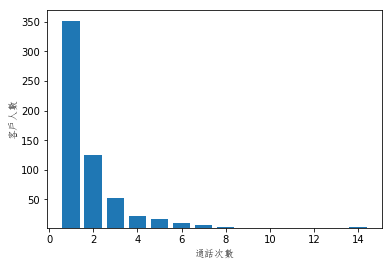

In [105]:
## First, get how many phonecalls per client
import matplotlib.pyplot as plt
import matplotlib

CallOutList = {}
for row in clean_data:
    clienID = row[1]
    if clienID not in CallOutList:
        CallOutList[clienID] = 0
    CallOutList[clienID] += 1
CallOutNum = {}    
for clienID in CallOutList:
    if CallOutList[clienID] not in CallOutNum:
        CallOutNum[CallOutList[clienID]] = [0, []]
    CallOutNum[CallOutList[clienID]][0] += 1
    CallOutNum[CallOutList[clienID]][1].append(clienID)
    
keys = list(CallOutNum.keys())
values = [CallOutNum[key][0] for key in keys]


zhfont1 =  matplotlib.font_manager.FontProperties(fname='./simfang.ttf')
fig = plt.figure()
plt.xlabel('通話次數', fontproperties=zhfont1)
plt.ylabel('客戶人數', fontproperties=zhfont1)
plt.bar(keys, height=values, bottom=2.0)

keys, values

可以看到通話一次的客戶是最多的，有350人。所以接下來分成兩個部分去分析：分析只能通話一次兩次的客服紀錄內容、分析通話次數較高的客服內容，藉此優化推銷品質


In [106]:
LessPhoneCall = [1, 2]
MorePhoneCall = [3, 4, 5, 6, 7, 8, 14]

LessPhoneCallContent = [row[3] for row in clean_data if CallOutList[row[1]] in LessPhoneCall]
MorePhoneCallContent = [row[3] for row in clean_data if CallOutList[row[1]] in MorePhoneCall]
LessPhoneCallClient = [client for client in CallOutList if CallOutList[client] in LessPhoneCall]
MorePhoneCallClient = [client for client in CallOutList if CallOutList[client] in MorePhoneCall]

LessPhoneCallContent[:5], MorePhoneCallContent[:5], LessPhoneCallClient[:5], MorePhoneCallClient[:5]

(['[ECP] 去電確認開戶文件 客戶說後來去買美元保單就不開戶了',
  '推Q1',
  '"兒子要開戶未成年',
  '林O屏216022 家庭戶 有可能有這戶下單又嫌麻煩',
  '台幣 瑞興 轉介208'],
 ['[ECP]不方說  IPO MAIL',
  '[ECP] IPO 忙 先MAIL',
  '家庭戶 媽媽說女兒不開了，因為打工收入不穩定',
  '客戶來電說看到4年IPO 要美金的 先寄開戶文件',
  '去電確認外幣帳號是台北富邦'],
 ['AA2765', 'AA2778', 'AA2825', 'AA2826', 'AA2827'],
 ['AA3910', 'AA3167', 'AA2355', 'AA2829', 'AA2833'])

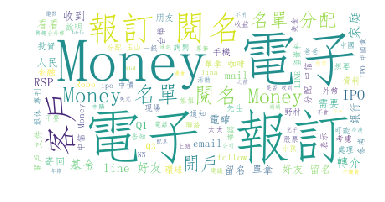

<Figure size 1000x1000 with 0 Axes>

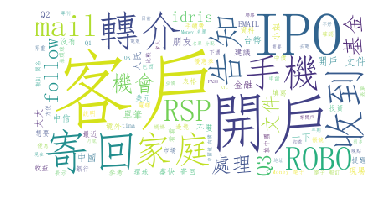

<Figure size 1000x1000 with 0 Axes>

In [107]:
import jieba
from wordcloud import WordCloud

def MakeWordCloud(contents):
    with open('stopwords.txt', 'r') as f:
        stopwords = [line.replace('\n', "") for line in f.readlines()]
    text = []
    for row in contents:
        row = jieba.cut(row)
        for term in row:
            if term not in stopwords:
                text.append(term)
                
    text = ",".join(text)
    
    wc = WordCloud(font_path="./simfang.ttf", #設置字體
               background_color="white",      #背景顏色
               max_words = 100 ,              #文字雲顯示最大詞數
               stopwords=stopwords)           #停用字詞
    wc.generate(text)
    plt.imshow(wc)
    plt.axis("off")
    plt.figure(figsize=(10,10), dpi = 100)
    plt.show()
    
MakeWordCloud(LessPhoneCallContent)
MakeWordCloud(MorePhoneCallContent)

In [102]:
# 做出TDM, 用客戶做區別。
LessClienteachPhoneCall = {}
MoreClienteachPhoneCall = {}

for client in LessPhoneCallClient:
    for row in clean_data:
        if client == row[1]:
            if client not in LessClienteachPhoneCall:
                LessClienteachPhoneCall[client] = []
            LessClienteachPhoneCall[client].append(row[3])
            
for client in MorePhoneCallClient:
    for row in clean_data:
        if client == row[1]:
            if client not in MoreClienteachPhoneCall:
                MoreClienteachPhoneCall[client] = []
            MoreClienteachPhoneCall[client].append(row[3])

LessClienteachPhoneCall[LessPhoneCallClient[0]], MoreClienteachPhoneCall[MorePhoneCallClient[0]]

(['[ECP] 去電確認開戶文件 客戶說後來去買美元保單就不開戶了'],
 ['[ECP]不方說  IPO MAIL', '[ECP]問鋒裕要不要賣', '[ECP]對帳單有空會回  因不常家'])

In [103]:
import jieba
import jieba.posseg as pseg

LessTDM = None
MoreTDM = None
wanted_nature = ['n', 'a', 'nr', 'ns', 'nt', 'nz', 'v', 'vd', 'vn']
with open('stopwords.txt', 'r') as f:
        stopwords = [line.replace('\n', "") for line in f.readlines()]
def MakeWordDictIn1Row(line):
    WordDict = {}
    segment = pseg.cut(line)
    wanted_term = []
    for term, nature in segment:
            if term != ' ' and term not in stopwords and nature in wanted_nature:
                wanted_term.append(term)
    for term in wanted_term:
        if term not in WordDict:
            WordDict[term] = 0
        WordDict[term] += 1
        
    return WordDict


In [114]:
LessTDM = None
for client in LessClienteachPhoneCall:
    AllCall = ",".join(LessClienteachPhoneCall[client])
    WordDict = MakeWordDictIn1Row(AllCall)
    tmp_tdm = pandas.DataFrame(data=WordDict, index=[0])
    LessTDM = pandas.concat([LessTDM, tmp_tdm], ignore_index=True)

clientsID = list(LessClienteachPhoneCall.keys())
indexList = list(LessTDM.index.values)
d = {}
for idx in range(len(indexList)):
    d[indexList[idx]]=clientsID[idx]
LessTDM.rename(index=d, inplace=True)    
LessTDM = LessTDM.fillna(0)
LessTDM.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,丈夫,上班,上網,下來,下班,下表,下載,不作,不好意思,不想,...,領先,願,願留,願開,顧孫子,顯示,風,高,高興,高雄
AA2765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AA2778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AA2825,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AA2826,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AA2827,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
MoreTDM = None
for client in MoreClienteachPhoneCall:
    AllCall = ",".join(MoreClienteachPhoneCall[client])
    WordDict = MakeWordDictIn1Row(AllCall)
    tmp_tdm = pandas.DataFrame(data=WordDict, index=[0])
    MoreTDM = pandas.concat([MoreTDM, tmp_tdm], ignore_index=True)

MoreTDM = MoreTDM.fillna(0)
clientsID = list(MoreClienteachPhoneCall.keys())
indexList = list(MoreTDM.index.values)
d = {}
for idx in range(len(indexList)):
    d[indexList[idx]]=clientsID[idx]
MoreTDM.rename(index=d, inplace=True)
MoreTDM.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98]
99 99


,A股,丈夫,上班,上網,下修,下單,下班,不夠,不常,不理,...,額,願,願開,顛,高,高雄,黃,黃金,點選,齊
AA3910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AA3167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AA2355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AA2829,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AA2833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
# 以時間去看
import datetime
min_time = datetime.datetime(2018, 1, 1, 1, 0)
max_time = datetime.datetime(2018, 12, 31, 23, 59)

time_block = [datetime.datetime(2018, month, 1, 1, 1) for month in range(1, 13)]
time_block.append(datetime.datetime(2019, 1, 1, 1, 1))
time_block

[datetime.datetime(2018, 1, 1, 1, 1),
 datetime.datetime(2018, 2, 1, 1, 1),
 datetime.datetime(2018, 3, 1, 1, 1),
 datetime.datetime(2018, 4, 1, 1, 1),
 datetime.datetime(2018, 5, 1, 1, 1),
 datetime.datetime(2018, 6, 1, 1, 1),
 datetime.datetime(2018, 7, 1, 1, 1),
 datetime.datetime(2018, 8, 1, 1, 1),
 datetime.datetime(2018, 9, 1, 1, 1),
 datetime.datetime(2018, 10, 1, 1, 1),
 datetime.datetime(2018, 11, 1, 1, 1),
 datetime.datetime(2018, 12, 1, 1, 1),
 datetime.datetime(2019, 1, 1, 1, 1)]

In [56]:
CallOutListByTime = {}
CallOutContentByTime = {}
for row in clean_data:
    for idx in range(1, len(time_block)):
        if  time_block[idx-1] <= datetime.datetime.strptime(row[2], "%Y%m%d %H%M%S") < time_block[idx]:
            if time_block[idx-1] not in CallOutListByTime:
                CallOutListByTime[time_block[idx-1]] = 0
                CallOutContentByTime[time_block[idx-1]] = []
            CallOutListByTime[time_block[idx-1]] += 1
            CallOutContentByTime[time_block[idx-1]].append(row[3])
            

<BarContainer object of 12 artists>

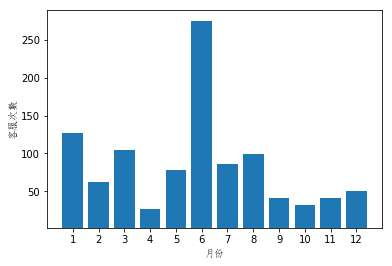

In [57]:
keys=["{}".format(key.month) for key in CallOutListByTime.keys()]
values=list(CallOutListByTime.values())

fig = plt.figure()
plt.xlabel('月份', fontproperties=zhfont1)
plt.ylabel('客服次數', fontproperties=zhfont1)
plt.bar(keys, height=values, bottom=2.0)


從圖中可以看出六月的客服次數非常高，所以我們分析看看六月到底都推銷了些什麼？
是因為推銷的產品呢，又或是因為是單一客戶的偏好呢(可能有些客戶就是習慣在六月買產品)？

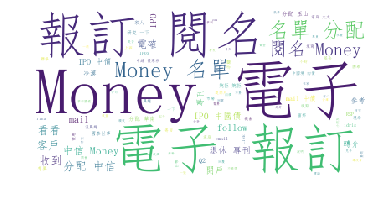

<Figure size 1000x1000 with 0 Axes>

In [58]:
MakeWordCloud(CallOutContentByTime[datetime.datetime(2018,6,1,1,1)])

In [62]:
UniqueClient=[]
ClientCall = {}
for row in clean_data:
    if datetime.datetime(2018,6,1,1,1) < datetime.datetime.strptime(row[2], "%Y%m%d %H%M%S") < datetime.datetime(2018,7,1,1,1):
        if row[1] not in UniqueClient:
            UniqueClient.append(row[1])
            ClientCall[row[1]] = [0, []]
        ClientCall[row[1]][0] += 1
        ClientCall[row[1]][1].append(row[3])

        
        
len(UniqueClient)


211

<BarContainer object of 5 artists>

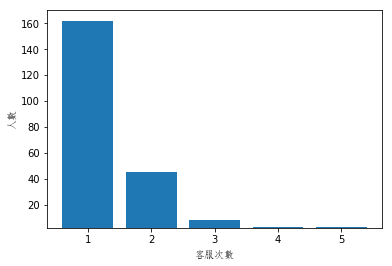

In [82]:
ClientCallTimes = [call[0] for call in ClientCall.values()]
CallOutNum = {}
for term in ClientCallTimes:
    if term not in CallOutNum:
        CallOutNum[term] = 0
    CallOutNum[term] += 1
    
keys = list(CallOutNum.keys())
values = list(CallOutNum.values())

fig = plt.figure()
plt.xlabel('客服次數', fontproperties=zhfont1)
plt.ylabel('人數', fontproperties=zhfont1)
plt.bar(keys, height=values, bottom=2.0)

多數的客戶都只打了一通，但也有40,50個客戶是打了超過兩通，我們來研究看看

In [87]:
#分析 在六月打了兩通以上的客戶，到底講了什麼
content = []
for client in ClientCall:
    if ClientCall[client][0] >= 2:
        for row in ClientCall[client][1]:
            content.append(row)
            
content[:5]

['[ECP]沒信心 沒錢 IPO',
 '"[ECP]帳號過長需修正',
 '"[ECP]電確',
 '[ECP]本來想要賣4年期 有資需求',
 'Money名單分配  款台外 轉介559']

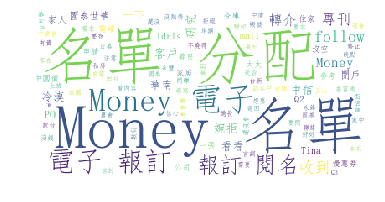

<Figure size 1000x1000 with 0 Axes>

In [88]:
MakeWordCloud(content)

”名單“在六月的打超過兩通以上的客戶客服紀錄頻繁出現